In [1]:
import warnings
warnings.filterwarnings('ignore')

import gc
import os
import cv2
import math
import numpy as np 
from tqdm import tqdm 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import albumentations as alb
from tensorflow.keras.datasets import cifar10
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model 
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras import callbacks
from sklearn.metrics import confusion_matrix

In [2]:
from tensorflow.keras.layers import (
    Input, Conv2D, PReLU, BatchNormalization,
    Dropout, MaxPooling2D, GlobalAveragePooling2D,
    Activation, Dense, LeakyReLU
)

In [3]:
physical_device = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_device[0], True)

In [4]:
tf.config.optimizer.set_experimental_options({"auto_mixed_precision": True})
print('Mixed precision enabled')

Mixed precision enabled


In [5]:
class DataLoader(tf.keras.utils.Sequence):
    def __init__(self, x, y, list_IDs, batch_size, shuffle=False, augment=True, labels=True, imagenet=False):
        self.x = x
        self.y = y
        self.augment = augment
        self.shuffle = shuffle
        self.batch_size = batch_size
        self.labels = labels
        self.list_IDs = list_IDs
        self.imagenet = imagenet
        self.on_epoch_end()
    
    def __len__(self):
        return int(np.floor(len(self.list_IDs) / self.batch_size))
    
    def __getitem__(self, idx):
        indexes = self.indexes[idx*self.batch_size:(idx+1)*self.batch_size]
        x, y = self.__data_generation(indexes)
        if self.augment:
            x = self.augment_(x)
        return x, y
    
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
    
    def __data_generation(self, indexes):
        X = self.x[indexes]
        Y = self.y[indexes]
        return X, Y
        
    
    def random_transform(self, img):
        mean = (0.485, 0.456, 0.406)
        std = (0.229, 0.224, 0.225)
        if self.labels:
            mean = (0.5071, 0.4867, 0.4408)
            std = (0.2675, 0.2565, 0.2761)
            mean = (0, 0, 0)
            std = (1, 1, 1)
            composition = alb.Compose(
            [
                alb.Normalize(mean, std, max_pixel_value=255.0, always_apply=True),
                alb.Resize(32, 32, always_apply=True),
                alb.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1, rotate_limit=15),
                alb.Flip(p=0.1),
                alb.Transpose(p=0.1),
                alb.Rotate(p=0.1),
                alb.RandomBrightness(p=0.1),
            ]
        )
            return composition(image=img)['image']
            
        else:
            mean = (0.5071, 0.4867, 0.4408)
            std = (0.2675, 0.2565, 0.2761)
            mean = (0, 0, 0)
            std = (1, 1, 1)
            composition = alb.Compose(
            [
                alb.Normalize(mean, std, max_pixel_value=255.0, always_apply=True),
                alb.Resize(32, 32, always_apply=True)
            ]
        )
            return composition(image=img)['image']
            

    def augment_(self, image_batch):
        images = []
        for i in range(image_batch.shape[0]):
            images.append(self.random_transform(image_batch[i, ]))
        images = np.array(images)
        return images

In [6]:
def residual_block(x, i):
    a = x
    for i in range(3):
        x = Conv2D(2**(5+i), kernel_size=3, padding='same', dilation_rate=2)(x)
        x = BatchNormalization()(x)
        x = LeakyReLU()(x)
        x = Dropout(0.2)(x)
    a = Conv2D(2**(5+i), kernel_size=1)(a)
    x = tf.math.add(x, a)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = Dropout(0.2)(x)
    return x

def simple_model(shape):
    inp_x = Input(shape=shape)
    x = Conv2D(32, kernel_size=1)(inp_x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    for i in range(2):
        x = residual_block(x, i)
    x = GlobalAveragePooling2D()(x)
    x = Dense(100)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = Dropout(0.4)(x)
    x = Dense(10, activation='softmax')(x)
    model = Model(inp_x, x)
    return model

In [7]:
def learning_rate_fn(epoch):
    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        lr = LR_MAX * LR_STEP_DECAY**((epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS)//10)
    return lr

In [8]:
(x_train, y_train), (x_val, y_val)= cifar10.load_data()

In [9]:
labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [10]:
train_list_IDs = np.arange(0, len(x_train))
val_list_IDs = np.arange(0, len(x_val))

In [11]:
LR_START = 1e-5
LR_MAX = 1e-3
LR_RAMPUP_EPOCHS = 5
LR_SUSTAIN_EPOCHS = 0
LR_STEP_DECAY = 0.75

callbacks = tf.keras.callbacks.LearningRateScheduler(learning_rate_fn, verbose=True)

In [12]:
# with strategy.scope():
simple_model = simple_model((32, 32, 3))

In [13]:
BATCH_SIZE = 64
EPOCHS = 40

In [14]:
train_gen = DataLoader(
    x_train, y_train, train_list_IDs, 
    batch_size=BATCH_SIZE, augment=True, 
    shuffle=True, labels=True
)
val_gen = DataLoader(
    x_val, y_val, val_list_IDs, 
    batch_size=BATCH_SIZE, labels=False
)

In [15]:
simple_model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(lr=1e-3), metrics=['sparse_categorical_accuracy'])

In [16]:
simple_model_history = simple_model.fit(train_gen, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(val_gen), callbacks=[callbacks])


Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
Epoch 1/40
781/781 [==============================] - 41s 53ms/step - loss: 2.3132 - sparse_categorical_accuracy: 0.2032 - val_loss: 2.1297 - val_sparse_categorical_accuracy: 0.2432

Epoch 00002: LearningRateScheduler reducing learning rate to 0.000208.
Epoch 2/40
781/781 [==============================] - 42s 54ms/step - loss: 1.9240 - sparse_categorical_accuracy: 0.3133 - val_loss: 1.6377 - val_sparse_categorical_accuracy: 0.4125

Epoch 00003: LearningRateScheduler reducing learning rate to 0.000406.
Epoch 3/40
781/781 [==============================] - 43s 55ms/step - loss: 1.6756 - sparse_categorical_accuracy: 0.3973 - val_loss: 1.4258 - val_sparse_categorical_accuracy: 0.4855

Epoch 00004: LearningRateScheduler reducing learning rate to 0.0006039999999999999.
Epoch 4/40
781/781 [==============================] - 43s 55ms/step - loss: 1.5134 - sparse_categorical_accuracy: 0.4595 - val_loss: 1.3170 - val_sparse_cat


Epoch 00033: LearningRateScheduler reducing learning rate to 0.0005625000000000001.
Epoch 33/40
781/781 [==============================] - 41s 52ms/step - loss: 0.7894 - sparse_categorical_accuracy: 0.7252 - val_loss: 0.5831 - val_sparse_categorical_accuracy: 0.8047

Epoch 00034: LearningRateScheduler reducing learning rate to 0.0005625000000000001.
Epoch 34/40
781/781 [==============================] - 41s 53ms/step - loss: 0.7808 - sparse_categorical_accuracy: 0.7293 - val_loss: 0.6347 - val_sparse_categorical_accuracy: 0.7811

Epoch 00035: LearningRateScheduler reducing learning rate to 0.0005625000000000001.
Epoch 35/40
781/781 [==============================] - 41s 53ms/step - loss: 0.7796 - sparse_categorical_accuracy: 0.7309 - val_loss: 0.6014 - val_sparse_categorical_accuracy: 0.7987

Epoch 00036: LearningRateScheduler reducing learning rate to 0.000421875.
Epoch 36/40
781/781 [==============================] - 41s 53ms/step - loss: 0.7566 - sparse_categorical_accuracy: 0.7371

In [17]:
def plot(data, model_name):
    plt.subplot(2,2,1)
    plt.plot(np.arange(EPOCHS), data.history['loss'], label='TRAIN LOSS')
    plt.plot(np.arange(EPOCHS), data.history['val_loss'], label='VAL LOSS')
    plt.xlabel('EPOCHS')
    plt.ylabel('LOSS')
    plt.legend()
    plt.subplot(2,2,2)
    plt.plot(np.arange(EPOCHS), data.history['sparse_categorical_accuracy'], label='TRAIN ACC')
    plt.plot(np.arange(EPOCHS), data.history['val_sparse_categorical_accuracy'], label='VAL ACC')
    plt.xlabel('EPOCHS')
    plt.ylabel('ACC')
    plt.title(f'{model_name}')
    plt.legend()

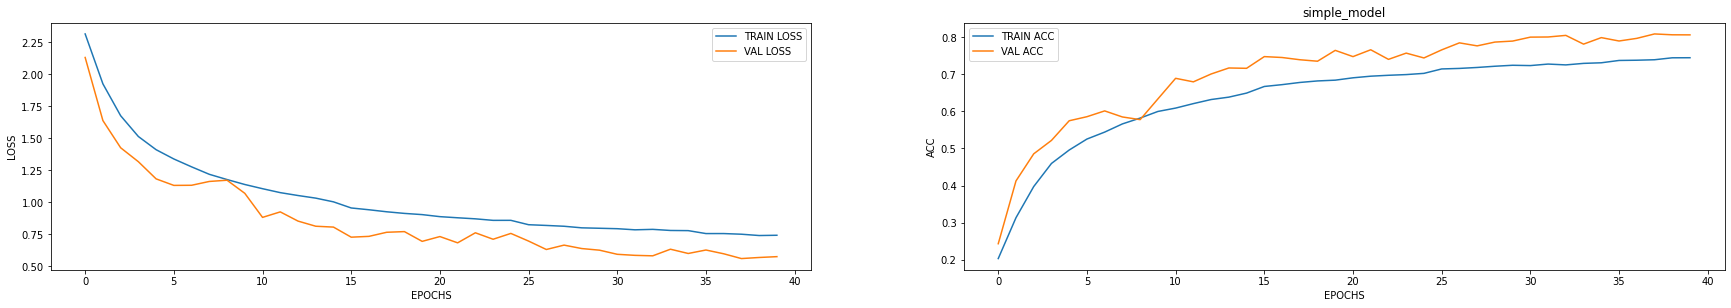

In [18]:
x = {
    'simple_model' : simple_model_history
}
plt.figure(figsize=(30, 10))
for num, (model_name, data) in enumerate(x.items()):
    plt.subplot(2, 2, num + 1)
    plot(data, model_name)
plt.show()

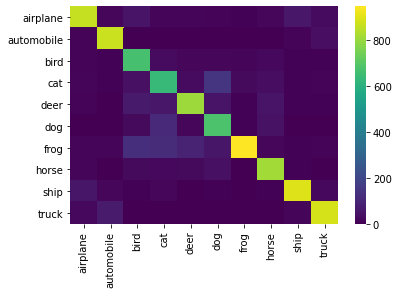

In [19]:
x_val_ = val_gen.augment_(x_val)
predictions = simple_model.predict(x_val_).argmax(axis=-1)
x = confusion_matrix(predictions, y_val)
sns.heatmap(x, xticklabels=labels, yticklabels=labels, cmap='viridis')
plt.show()